# Expresion
Datos de expresión extraidos de:
https://ccb-web.cs.uni-saarland.de/tissueatlas2/downloads

In [97]:
import pandas as pd 
import seaborn as sns
import multiprocessing as mp
from tqdm import tqdm
import ast
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [19]:
dft = pd.read_csv('../../Data/Estratos/Pathways/Contribution_miRNA_time_pathwayGO_BP.tsv', sep = '\t')
dfv = pd.read_csv('../../Data/Estratos/Pathways/Contribution_miRNA_variant_pathwayGO_BP.tsv', sep = '\t')
dfs = pd.read_csv('../../Data/Estratos/Pathways/Contribution_miRNA_spectral_pathwayGO_BP.tsv', sep = '\t')
dfsp = pd.read_csv('../../Data/Estratos/Pathways/Contribution_miRNA_spectrum_pathwayGO_BP.tsv', sep = '\t')
dfgt = pd.read_csv('../../Data/Estratos/Pathways/Contribution_miRNA_ConstantClusters_pathwayGO_BP.tsv', sep = '\t')

dfv.head()

,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR
0,circadian behavior,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85"
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85"
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85"
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85"
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85"


In [20]:
# estan en el primero, pero no en el segundo 
#len(set(dft[dft['Variant']=='(2010-12-05,2020-03-01]']['miRNA']) - set(dft[dft['Variant']=='Global']['miRNA']))

In [21]:
df_expression = pd.read_csv('../../Data/hsa_snc_expression.csv')
df_expression.head()

,source,norm,body,organ,tissue,type,acc,expression,species
0,ngs,rpmm,3,adipocyte,adipocyte,trna,tRNA-Ala-AGC-1-1,88.905542,hsa
1,ngs,rpmm,3,adipocyte,adipocyte,trna,tRNA-Ala-AGC-10-1,0.000000,hsa
2,ngs,rpmm,3,adipocyte,adipocyte,trna,tRNA-Ala-AGC-10-2,0.000000,hsa
3,ngs,rpmm,3,adipocyte,adipocyte,trna,tRNA-Ala-AGC-11-1,47.789356,hsa
4,ngs,rpmm,3,adipocyte,adipocyte,trna,tRNA-Ala-AGC-12-1,0.000000,hsa


In [22]:
tissues_ACE2 = ['brain', 'esophagus', 'lung', 'heart', 'kidney', 'stomach', 'gallbladder', 'liver', 'pancreas', 'bowel', 'vein', 'artery']
df_expression_sars = df_expression[df_expression['organ'].isin(tissues_ACE2)]
df_expression_sars = df_expression_sars[df_expression_sars['expression'] > 0]
df_expression_sars = df_expression_sars[df_expression_sars['type'] == 'mirna']
df_expression_sars

,source,norm,body,organ,tissue,type,acc,expression,species
171936,ngs,rpmm,1,kidney,kidney,mirna,hsa-let-7a-2-3p,0.500669,hsa
171937,ngs,rpmm,1,kidney,kidney,mirna,hsa-let-7a-3p,95.600018,hsa
171938,ngs,rpmm,1,kidney,kidney,mirna,hsa-let-7a-5p,2403.045671,hsa
171939,ngs,rpmm,1,kidney,kidney,mirna,hsa-let-7b-3p,13.907480,hsa
171940,ngs,rpmm,1,kidney,kidney,mirna,hsa-let-7b-5p,9122.861906,hsa
...,...,...,...,...,...,...,...,...,...
16411643,ngs,rpmm,3,liver,liver,mirna,hsa-miR-9986,0.251370,hsa
16411644,ngs,rpmm,3,liver,liver,mirna,hsa-miR-99a-3p,117.724918,hsa
16411645,ngs,rpmm,3,liver,liver,mirna,hsa-miR-99a-5p,3356.039952,hsa
16411646,ngs,rpmm,3,liver,liver,mirna,hsa-miR-99b-3p,6.591478,hsa


In [23]:
def extract_expression(miRNA):
    if miRNA in list(df_expression_sars['acc']):
        keys =  df_expression_sars[df_expression_sars['acc'] == miRNA]['organ']
        values = df_expression_sars[df_expression_sars['acc'] == miRNA]['expression']
        dictionary = dict(zip(keys, values))
        return dictionary
    else:
        return 0

In [24]:
# Crea un pool de procesos
pool = mp.Pool(mp.cpu_count())
pbar = tqdm(total=len(dft['miRNA']))
def update(*a):
    pbar.update()
results = []
for miRNA in dft['miRNA']:
    result = pool.apply_async(extract_expression, args=(miRNA,), callback=update)
    results.append(result)
pool.close()
pool.join()
dft['Expression'] = [result.get() for result in results]
pbar.close()

dft.head()

100%|██████████| 137914/137914 [12:45<00:00, 180.19it/s]


,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression
0,circadian behavior,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."


In [25]:
# Crea un pool de procesos
pool = mp.Pool(mp.cpu_count())
pbar = tqdm(total=len(dfv['miRNA']))
def update(*a):
    pbar.update()
results = []
for miRNA in dfv['miRNA']:
    result = pool.apply_async(extract_expression, args=(miRNA,), callback=update)
    results.append(result)
pool.close()
pool.join()
dfv['Expression'] = [result.get() for result in results]
pbar.close()

dfv.head()

100%|██████████| 551430/551430 [50:26<00:00, 182.20it/s]


,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression
0,circadian behavior,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946..."


In [26]:
# Crea un pool de procesos
pool = mp.Pool(mp.cpu_count())
pbar = tqdm(total=len(dfs['miRNA']))
def update(*a):
    pbar.update()
results = []
for miRNA in dfs['miRNA']:
    result = pool.apply_async(extract_expression, args=(miRNA,), callback=update)
    results.append(result)
pool.close()
pool.join()
dfs['Expression'] = [result.get() for result in results]
pbar.close()

dfs.head()

100%|██████████| 97541/97541 [08:55<00:00, 182.30it/s]


,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression
0,circadian behavior,0.034054,hsa-miR-638,G2,-34.5,0.84,5'UTR,>G2:67-125,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,G2,-34.5,0.84,5'UTR,>G2:67-125,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,G2,-34.5,0.84,5'UTR,>G2:67-125,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,G2,-34.5,0.84,5'UTR,>G2:67-125,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,G2,-34.5,0.84,5'UTR,>G2:67-125,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."


In [27]:
# Crea un pool de procesos
pool = mp.Pool(mp.cpu_count())
pbar = tqdm(total=len(dfsp['miRNA']))
def update(*a):
    pbar.update()
results = []
for miRNA in dfsp['miRNA']:
    result = pool.apply_async(extract_expression, args=(miRNA,), callback=update)
    results.append(result)
pool.close()
pool.join()
dfsp['Expression'] = [result.get() for result in results]
pbar.close()

dfsp.head()

100%|██████████| 60948/60948 [05:29<00:00, 184.91it/s]


,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression
0,circadian behavior,0.034054,hsa-miR-638,Gs2,-34.5,0.84,5'UTR,>Gs2:45-173,"45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,Gs2,-34.5,0.84,5'UTR,>Gs2:45-173,"45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,Gs2,-34.5,0.84,5'UTR,>Gs2:45-173,"45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,Gs2,-34.5,0.84,5'UTR,>Gs2:45-173,"45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,Gs2,-34.5,0.84,5'UTR,>Gs2:45-173,"45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946..."


In [28]:
# Crea un pool de procesos
pool = mp.Pool(mp.cpu_count())
pbar = tqdm(total=len(dfgt['miRNA']))
def update(*a):
    pbar.update()
results = []
for miRNA in dfgt['miRNA']:
    result = pool.apply_async(extract_expression, args=(miRNA,), callback=update)
    results.append(result)
pool.close()
pool.join()
dfgt['Expression'] = [result.get() for result in results]
pbar.close()

dfgt.head()

100%|██████████| 37529/37529 [03:26<00:00, 181.99it/s]


,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression
0,circadian behavior,0.034054,hsa-miR-638,Gst1,-34.5,0.84,5'UTR,>Gst1:67-209,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,Gst1,-34.5,0.84,5'UTR,>Gst1:67-209,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,Gst1,-34.5,0.84,5'UTR,>Gst1:67-209,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,Gst1,-34.5,0.84,5'UTR,>Gst1:67-209,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,Gst1,-34.5,0.84,5'UTR,>Gst1:67-209,"23,47","{'bowel': 0.0834956488747458, 'brain': 0.06946..."


In [29]:
dft.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_time.tsv', index = False, sep = '\t')
dfv.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_variant.tsv', index = False, sep = '\t')
dfs.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectral.tsv', index = False, sep = '\t')
dfsp.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectrum.tsv', index = False, sep = '\t')
dfgt.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_ContantClusters.tsv', index = False, sep = '\t')

# Preprocessing

In [30]:
dft = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_time.tsv', sep = '\t')
dfv = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_variant.tsv', sep = '\t')
dfs = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectral.tsv', sep = '\t')
dfsp = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectrum.tsv', sep = '\t')
dfgt = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_ContantClusters.tsv', sep = '\t')

len(dfv)

551430

In [31]:
dft['Expression'] = dft['Expression'].apply(ast.literal_eval)
expanded_dft = dft['Expression'].apply(pd.Series)
dft = pd.concat([dft, expanded_dft], axis=1)


dfv['Expression'] = dfv['Expression'].apply(ast.literal_eval)
expanded_dfv = dfv['Expression'].apply(pd.Series)
dfv = pd.concat([dfv, expanded_dfv], axis=1)

dfs['Expression'] = dfs['Expression'].apply(ast.literal_eval)
expanded_dfs = dfs['Expression'].apply(pd.Series)
dfs = pd.concat([dfs, expanded_dfs], axis=1)

dfsp['Expression'] = dfsp['Expression'].apply(ast.literal_eval)
expanded_dfsp = dfsp['Expression'].apply(pd.Series)
dfsp = pd.concat([dfsp, expanded_dfsp], axis=1)

dfgt['Expression'] = dfgt['Expression'].apply(ast.literal_eval)
expanded_dfgt = dfgt['Expression'].apply(pd.Series)
dfgt = pd.concat([dfgt, expanded_dfgt], axis=1)

dfv.head()

,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression,...,lung,esophagus,kidney,artery,heart,vein,pancreas,stomach,liver,0
0,circadian behavior,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,20A,-34.5,0.84,5'UTR,>20A:29-173,"61,85","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
dft.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_time.tsv', index = False, sep = '\t')
dfv.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_variant.tsv', index = False, sep = '\t')
dfs.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectral.tsv', index = False, sep = '\t')
dfsp.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectrum.tsv', index = False, sep = '\t')
dfgt.to_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_ContantClusters.tsv', index = False, sep = '\t')

# Filtro

In [33]:
dft = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_time.tsv', sep = '\t')
dfv = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_variant.tsv', sep = '\t')
dfs = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectral.tsv', sep = '\t')
dfsp = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_spectrum.tsv', sep = '\t')
dfgt = pd.read_csv('../../Data/Estratos/Pathways_Expression/miRNA_expression_pathways_ContantClusters.tsv', sep = '\t')
dft.head()

,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression,...,lung,esophagus,kidney,artery,heart,vein,pancreas,stomach,liver,0
0,circadian behavior,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,glycerophospholipid biosynthetic process,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,negative regulation of G1/S transition of mito...,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,negative regulation of cell cycle G1/S phase t...,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,negative regulation of epithelial to mesenchym...,0.034054,hsa-miR-638,"(2022-11-01,2023-01-01]",-34.5,0.84,5'UTR,">(2022-11-01,2023-01-01]:45-209","45,69","{'bowel': 0.0834956488747458, 'brain': 0.06946...",...,0.029673,0.034877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
dfft = dft[dft['lung']>10]
dffv = dfv[dfv['lung']>10]
dffs = dfs[dfs['lung']>10]
dffsp = dfsp[dfsp['lung']>10]
dffgt = dfgt[dfgt['lung']>10]

dfft

,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression,...,lung,esophagus,kidney,artery,heart,vein,pancreas,stomach,liver,0
1046,cellular response to parathyroid hormone stimulus,0.008178,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.812500,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.912480,128.365923,36.057620,NaN
1047,negative regulation of DNA-binding transcripti...,0.008178,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.812500,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.912480,128.365923,36.057620,NaN
1048,negative regulation of ossification,0.013669,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.812500,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.912480,128.365923,36.057620,NaN
1049,negative regulation of osteoblast differentiation,0.008178,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.812500,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.912480,128.365923,36.057620,NaN
1050,osteoblast differentiation,0.021794,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.812500,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.912480,128.365923,36.057620,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137864,signaling,0.040279,hsa-miR-32-5p,"(2023-01-01,2023-07-01]",-10.0,0.846154,3'UTR,">(2023-01-01,2023-07-01]:29824-29823","10,22","{'kidney': 986.1392385648332, 'brain': 499.595...",...,334.138224,185.935100,986.139239,161.922394,678.337589,395.051669,527.913189,1104.384081,772.599449,NaN
137865,system development,0.036244,hsa-miR-32-5p,"(2023-01-01,2023-07-01]",-10.0,0.846154,3'UTR,">(2023-01-01,2023-07-01]:29824-29823","10,22","{'kidney': 986.1392385648332, 'brain': 499.595...",...,334.138224,185.935100,986.139239,161.922394,678.337589,395.051669,527.913189,1104.384081,772.599449,NaN
137866,telencephalon development,0.019501,hsa-miR-32-5p,"(2023-01-01,2023-07-01]",-10.0,0.846154,3'UTR,">(2023-01-01,2023-07-01]:29824-29823","10,22","{'kidney': 986.1392385648332, 'brain': 499.595...",...,334.138224,185.935100,986.139239,161.922394,678.337589,395.051669,527.913189,1104.384081,772.599449,NaN
137867,tube formation,0.038178,hsa-miR-32-5p,"(2023-01-01,2023-07-01]",-10.0,0.846154,3'UTR,">(2023-01-01,2023-07-01]:29824-29823","10,22","{'kidney': 986.1392385648332, 'brain': 499.595...",...,334.138224,185.935100,986.139239,161.922394,678.337589,395.051669,527.913189,1104.384081,772.599449,NaN


In [35]:
dfft.to_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_time_Filter.tsv', sep = '\t', index = False)
dffv.to_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_SinEstructuras_variant_Filter.tsv', sep = '\t', index = False)
dffs.to_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_spectral_Filter.tsv', sep = '\t', index = False)
dffsp.to_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_spectrum_Filter.tsv', sep = '\t', index = False)
dffgt.to_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_ConstantClusters_Filter.tsv', sep = '\t', index = False)

# Inspection

In [86]:
dfft = pd.read_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_time_Filter.tsv', sep = '\t')
dffv = pd.read_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_SinEstructuras_variant_Filter.tsv', sep = '\t')
dffs = pd.read_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_spectral_Filter.tsv', sep = '\t')
dffsp = pd.read_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_spectrum_Filter.tsv', sep = '\t')
dffgt = pd.read_csv('../../Data/Estratos/Pathways_ExpressionFilter/Expanded_miRNAPredicted_ConstantClusters_Filter.tsv', sep = '\t')
dfft.head()

,function,p_value,miRNA,Variant,DuplexEnergy,Jaccard,Region,UTR_region,InteractionRegionUTR,Expression,...,lung,esophagus,kidney,artery,heart,vein,pancreas,stomach,liver,0
0,cellular response to parathyroid hormone stimulus,0.008178,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.8125,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.91248,128.365923,36.05762,NaN
1,negative regulation of DNA-binding transcripti...,0.008178,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.8125,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.91248,128.365923,36.05762,NaN
2,negative regulation of ossification,0.013669,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.8125,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.91248,128.365923,36.05762,NaN
3,negative regulation of osteoblast differentiation,0.008178,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.8125,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.91248,128.365923,36.05762,NaN
4,osteoblast differentiation,0.021794,hsa-miR-381-3p,"(2010-12-05,2020-03-01]",-20.5,0.8125,3'UTR,">(2010-12-05,2020-03-01]:29763-29844","13,28","{'kidney': 47.3691337301885, 'brain': 282.3801...",...,12.382684,26.206047,47.369134,6.166493,28.999434,17.336111,26.91248,128.365923,36.05762,NaN


In [58]:
df_db2 = pd.read_csv('../../Data/Filters.tsv', sep = '\t')
df_db2

,Variant,count,Table,Filter
0,"(2021-01-01,2021-05-01]",63742,dft,Global
1,"(2020-09-01,2021-01-01]",58431,dft,Global
2,"(2021-05-01,2022-01-01]",58416,dft,Global
3,"(2023-07-01,2023-09-06]",50448,dft,Global
4,"(2023-01-01,2023-07-01]",47792,dft,Global
...,...,...,...,...
113,G3,1361,dfsf,Jaccard_Duplex
114,Gs1,1361,dfspf,Jaccard_Duplex
115,Gs3,1255,dfspf,Jaccard_Duplex
116,Gs2,1029,dfspf,Jaccard_Duplex


In [89]:
def extract_region(string):
    return string.split(':')[1]

df_list = [dfft, dffv, dffs, dffsp, dffgt]
df_db = pd.DataFrame()
df_db3 = pd.DataFrame()

for i in df_list:
    df_name = [name for name in globals() if globals()[name] is i]
    
    ii = i[i['Variant']!='Global']
    ii['UTR_region']= list(map(extract_region, ii['UTR_region']))

    ii = ii[['miRNA', 'Variant', 'Region', 'UTR_region']]
    ii = ii.drop_duplicates(keep='last')

    df_ii = ii[['Variant', 'Region']].groupby('Variant').value_counts().reset_index()
    df_ii['V'] = df_name[0]

    df_i = ii['Variant'].value_counts().reset_index()
    df_i['Table'] = [df_name[0]] * len(df_i)
    df_i['Filter'] = 'Expression'


    df_i3 = ii[['Variant', 'Region']].value_counts().reset_index()
    df_i3['Table'] = df_name[0]

    print(f'''
        Nombre: {df_name}
        Regiones con sitios consecutivos altamente conservados: {len(ii)}
        Promedio por variante: {ii['Variant'].value_counts().agg(['mean', 'std'], numeric_only=True)}
        Region:
            {ii[['Variant', 'Region']].groupby('Variant').value_counts().reset_index().drop(['Variant'], axis = 1).groupby('Region').agg(['mean', 'std'])},
        Sitios con mas miRNA:
            {ii[['Variant', 'UTR_region']].groupby('Variant').value_counts().reset_index().drop(['Variant'], axis = 1).groupby('UTR_region').agg(['mean', 'std']).sort_values(by=('count', 'mean'), ascending=False).head(35)}
        =============
    ''')
    print(df_ii)
    df_db = pd.concat([df_db, df_ii])
    df_db2 = pd.concat([df_db2, df_i])
    df_db3 = pd.concat([df_db3, df_i3])



        Nombre: ['dfft', 'i']
        Regiones con sitios consecutivos altamente conservados: 893
        Promedio por variante: mean    89.300000
std     11.972654
Name: count, dtype: float64
        Region:
                   count           
        mean        std
Region                 
3'UTR   26.8   4.157991
5'UTR   62.5  13.607596,
        Sitios con mas miRNA:
                         count          
              mean       std
UTR_region                  
256-255      26.60  4.427189
62-99        23.00  0.000000
45-192       21.00       NaN
45-202       21.00  0.000000
45-209       19.00  0.000000
29-240       18.00       NaN
26-173       18.00       NaN
67-240       17.00       NaN
175-200      15.00       NaN
29780-29860  14.00       NaN
204-217      13.00       NaN
175-202      13.00  0.000000
29782-29809  13.00  0.000000
128-127      13.00  0.000000
204-240      11.00       NaN
29763-29844  11.00       NaN
29785-29809   9.00  0.000000
29824-29823   8.25  1.908627
29701-

In [17]:
df_db.head()

,Variant,Region,count,V
0,"(2010-12-05,2020-03-01]",5'UTR,46,dfft
1,"(2010-12-05,2020-03-01]",3'UTR,27,dfft
2,"(2020-03-01,2020-09-01]",5'UTR,52,dfft
3,"(2020-03-01,2020-09-01]",3'UTR,24,dfft
4,"(2020-09-01,2021-01-01]",5'UTR,85,dfft


In [66]:
d ={
    "['i', 'df_vf']": 'Variantes' ,
    'dffv': 'Variantes',
    "df_vf":'Variantes',
    "dfv": 'Variantes',
    "dft": 'Clusters temporales',
    "dfft":'Clusters temporales',
    "df_tf":'Clusters temporales',
    "['i', 'df_tf']":'Clusters temporales',
    "['i', 'dfsf']": 'Clusters',
    "dfsf": 'Clusters',
    "dfs":'Clusters',
    "dffs":'Clusters',
    "['i', 'dfspf']":'Clusters geograficos',
    "dfsp": 'Clusters geograficos',
    "dfspf":'Clusters geograficos',
    "dffsp":'Clusters geograficos',
    "['i', 'dfgtf']":'Clusters constantes en t',
    "dfgtf":'Clusters constantes en t',
    "dfgt" :'Clusters constantes en t',
    "dffgt" :'Clusters constantes en t',
}
df_db2['Table'].replace(d, inplace = True)
df_db2['Table'].value_counts()

/tmp/ipykernel_5273/1685161480.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_db2['Table'].replace(d, inplace = True)


Table
Variantes                   114
Clusters temporales          30
Clusters                     15
Clusters geograficos         12
Clusters constantes en t      6
Name: count, dtype: int64

In [68]:
df_db2.to_csv('../../Data/Filters.tsv', sep = '\t')
df_db2

,Variant,count,Table,Filter
0,"(2021-01-01,2021-05-01]",63742,Clusters temporales,Global
1,"(2020-09-01,2021-01-01]",58431,Clusters temporales,Global
2,"(2021-05-01,2022-01-01]",58416,Clusters temporales,Global
3,"(2023-07-01,2023-09-06]",50448,Clusters temporales,Global
4,"(2023-01-01,2023-07-01]",47792,Clusters temporales,Global
...,...,...,...,...
1,Gs3,100,Clusters geograficos,Expression
2,Gs4,88,Clusters geograficos,Expression
3,Gs2,79,Clusters geograficos,Expression
0,Gst2,121,Clusters constantes en t,Expression


In [90]:
df_db3

,Variant,Region,count,Table
0,"(2021-01-01,2021-05-01]",5'UTR,87,dfft
1,"(2020-09-01,2021-01-01]",5'UTR,85,dfft
2,"(2021-05-01,2022-01-01]",5'UTR,65,dfft
3,"(2023-01-01,2023-07-01]",5'UTR,63,dfft
4,"(2022-06-01,2022-11-01]",5'UTR,62,dfft
...,...,...,...,...
7,Gs2,3'UTR,14,dffsp
0,Gst2,5'UTR,92,dffgt
1,Gst1,5'UTR,60,dffgt
2,Gst1,3'UTR,33,dffgt


In [92]:
df_db3 = df_db3[df_db3['Table']!='dffs']
DF5 = df_db3[df_db3['Region']=="5'UTR"]
DF3 = df_db3[df_db3['Region']=="3'UTR"]

In [95]:
counts = DF5['count']

# Realizar la prueba de Shapiro-Wilk
stat, p_value = stats.shapiro(counts)
print(f'Estadístico: {stat}, p-valor: {p_value}')


model = ols('count ~ C(Table)', data=DF5).fit()

# Realizar el ANOVA
anova_table = sm.stats.anova_lm(model)
print(anova_table)

Estadístico: 0.9583089351654053, p-valor: 0.05789180099964142
            df   sum_sq  mean_sq         F   PR(>F)
C(Table)   3.0  1740.75  580.250  3.385652  0.02513
Residual  50.0  8569.25  171.385       NaN      NaN


In [99]:
tukey_result = pairwise_tukeyhsd(endog=DF5['count'], groups=DF5['Table'], alpha=0.05)
print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 dffgt  dffsp   -13.25 0.6491 -43.3804 16.8804  False
 dffgt   dfft    -13.5 0.5478 -40.4494 13.4494  False
 dffgt   dffv    -23.0  0.086 -48.2404  2.2404  False
 dffsp   dfft    -0.25    1.0  -20.833  20.333  False
 dffsp   dffv    -9.75  0.495 -28.0384  8.5384  False
  dfft   dffv     -9.5 0.1867 -21.8652  2.8652  False
-----------------------------------------------------


In [100]:
counts = DF3['count']

# Realizar la prueba de Shapiro-Wilk
stat, p_value = stats.shapiro(counts)
print(f'Estadístico: {stat}, p-valor: {p_value}')


model = ols('count ~ C(Table)', data=DF3).fit()

# Realizar el ANOVA
anova_table = sm.stats.anova_lm(model)
print(anova_table)

Estadístico: 0.9833433628082275, p-valor: 0.6527602672576904
            df       sum_sq    mean_sq         F    PR(>F)
C(Table)   3.0    59.426803  19.808934  0.436192  0.728058
Residual  50.0  2270.665789  45.413316       NaN       NaN


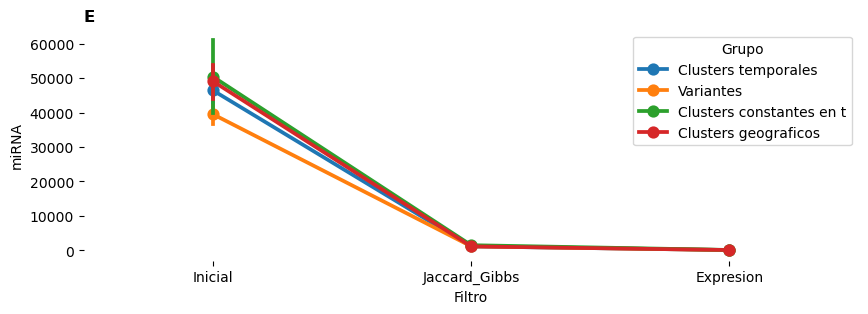

In [85]:
plt.figure(figsize=(10, 3))
sns.pointplot(data=df_db2[df_db2['Table']!='Clusters'], x="Filter", y="count", hue="Table")

# Cambiar los títulos de los ejes
plt.ylabel('miRNA')
plt.xlabel('Filtro')
plt.title("E", fontweight="bold", loc = 'left')
# Cambiar las etiquetas de los ticks del eje X
plt.xticks(ticks=[0, 1, 2], labels=['Inicial', 'Jaccard_Gibbs', 'Expresion'])
sns.despine(left=True, bottom=True)
plt.legend(title='Grupo')
plt.savefig('../../Plots/miRNAcount.pdf', bbox_inches = 'tight')

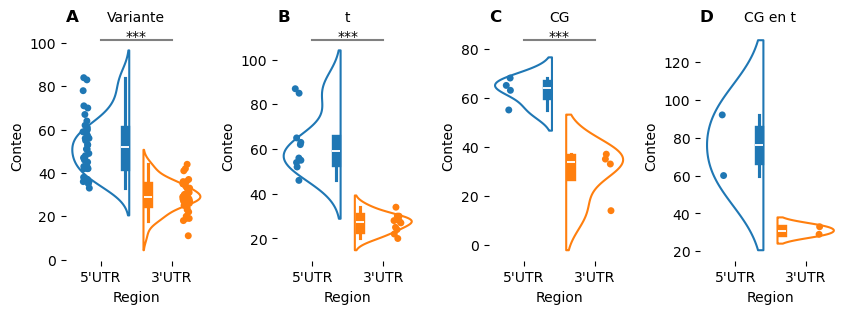

In [71]:
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 4)


#===================================== Third plot on the top =============================
ax3 = fig.add_subplot(gs[0, 0])
sns.violinplot(data=df_db[df_db['V'] == 'dffv'], x="Region", y='count', hue="Region", fill=False, ax = ax3, split = True)
sns.stripplot(data=df_db[df_db['V'] == 'dffv'], x="Region", y='count', hue="Region", dodge=True, jitter=True, ax=ax3)

# Barra de significancia
y_max = max(df_db[df_db['V'] == 'dffv']['count']) + 10
y_min = min(df_db[df_db['V'] == 'dffv']['count']) + 10
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("A", fontweight="bold", loc = 'left')
ax3.set_title('Variante', fontsize=10)

#===================================== Third plot on the top =============================
ax4 = fig.add_subplot(gs[0, 1])
sns.violinplot(data=df_db[df_db['V'] == 'dfft'], x="Region", y='count', hue="Region", fill=False, ax = ax4, split = True)
sns.stripplot(data=df_db[df_db['V'] == 'dfft'], x="Region", y='count', hue="Region", dodge=True, jitter=True, ax=ax4)

# Barra de significancia
y_max = max(df_db[df_db['V'] == 'dfft']['count']) + 15
y_min = min(df_db[df_db['V'] == 'dfft']['count']) + 15
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("B", fontweight="bold", loc = 'left')
ax4.set_title('t', fontsize=10)


#===================================== Four plot on the top =============================

ax5 = fig.add_subplot(gs[0, 2])
sns.violinplot(data=df_db[df_db['V'] == 'dffsp'], x="Region", y='count', hue="Region", fill=False, ax = ax5, split = True)
sns.stripplot(data=df_db[df_db['V'] == 'dffsp'], x="Region", y='count', hue="Region", dodge=True, jitter=True, ax=ax5)

# Barra de significancia
y_max = max(df_db[df_db['V'] == 'dffsp']['count']) + 10
y_min = min(df_db[df_db['V'] == 'dffsp']['count']) + 10
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("C", fontweight="bold", loc = 'left')
ax5.set_title('CG', fontsize=10)

#===================================== Four plot on the top =============================
ax6 = fig.add_subplot(gs[0, 3])
sns.violinplot(data=df_db[df_db['V'] == 'dffgt'], x="Region", y='count', hue="Region", fill=False, ax = ax6, split = True)
sns.stripplot(data=df_db[df_db['V'] == 'dffgt'], x="Region", y='count', hue="Region", dodge=True, jitter=True, ax=ax6)

plt.ylabel('Conteo')

plt.title("D", fontweight="bold", loc = 'left')
ax6.set_title('CG en t', fontsize=10)


#delete box
sns.despine(left=True, bottom=True)
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.savefig('../../Plots/FilterSummary.pdf', bbox_inches='tight')

In [15]:
def estadistico(df):
    df5 = df[df['Region'] == "5'UTR"]
    df3 = df[df['Region'] == "3'UTR"]


    shapiro_test5 = stats.shapiro(df5['count'])    
    shapiro_test3 = stats.shapiro(df3['count'])
    print(f'shapiro wilk{shapiro_test5.pvalue, shapiro_test3.pvalue}')

    if shapiro_test5.pvalue > 0.05 and shapiro_test3.pvalue > 0.05:
        print('t-student')
        test = stats.ttest_ind(df5['count'], df3['count'])
    else:
        print('mannwhitneu')
        test = stats.mannwhitneyu(df5['count'], df3['count'])
    return test


for i in df_db['V'].unique():
    print(i)
    if i == 'dffgt':
        continue 

    df_i = df_db[df_db['V']==i]
    test = estadistico(df_i)
    print(test)
    print('======')

dfft
shapiro wilk(0.08647800236940384, 0.972888171672821)
t-student
TtestResult(statistic=7.934204075662081, pvalue=2.756045691320784e-07, df=18.0)
dffv
shapiro wilk(0.12740221619606018, 0.8151289224624634)
t-student
TtestResult(statistic=9.932072568683315, pvalue=2.951094766970573e-15, df=74.0)
dffs
shapiro wilk(0.22797426581382751, 0.8259553909301758)
t-student
TtestResult(statistic=8.449641125913585, pvalue=2.9397816292616038e-05, df=8.0)
dffsp
shapiro wilk(0.5706448554992676, 0.05722946673631668)
t-student
TtestResult(statistic=5.503185635946222, pvalue=0.0015103771679425173, df=6.0)
dffgt
